# **Download da base de dados**

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download misrakahmed/vegetable-image-dataset
! unzip /content/vegetable-image-dataset.zip

# **Importação das imagens**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.utils import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
geratreino = ImageDataGenerator(
    rotation_range = 20,
    shear_range	= 0.2,
    zoom_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255
)
gerateste = ImageDataGenerator(
    rescale = 1./255
)

geravali = ImageDataGenerator(
    rescale = 1./255
)

treino = geratreino.flow_from_directory(
    directory = "/content/Vegetable Images/train",
    target_size = (150, 150),
    class_mode = "categorical",
)

teste = gerateste.flow_from_directory(
    directory = "/content/Vegetable Images/test",
    target_size = (150, 150),
    class_mode = "categorical",
)

valida = geravali.flow_from_directory(
    directory="/content/Vegetable Images/validation",
    target_size=(150, 150),
    class_mode = "categorical"
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# **Construção do Modelo**

Vamos ativar a TPU, caso seja necessário

In [ ]:
import tensorflow as tf
#Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.108.76.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.76.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


**Construção das camadas**

In [ ]:
modelo = Sequential()

# Conv + Batch + Pooling
modelo.add(Conv2D(
    filters = 32,
    kernel_size = 3,
    activation = "relu",
    input_shape = (150, 150, 3)
))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2,2)))


# Conv + Batch + Pooling
modelo.add(Conv2D(
    filters = 64,
    kernel_size = 3,
    activation = "relu"
))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2,2)))

# Conv + Batch + Pooling
modelo.add(Conv2D(
    filters = 128,
    kernel_size = 3,
    activation = "relu"
))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2,2)))



# Flatenning
modelo.add(Flatten())


# Rede Neural densa
modelo.add(Dense(
    units = 128,
    activation="relu"
))
modelo.add(Dropout(rate=0.3))


# Camada de saída
modelo.add(Dense(
    units = 15,
    activation = "softmax"
))


# Compilação
modelo.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Caso TPU esteja disponível, usar do seguinte modo:

In [ ]:
with strategy.scope():
  modelo = Sequential()

  # Conv + Batch + Pooling
  modelo.add(Conv2D(
      filters = 32,
      kernel_size = 3,
      activation = "relu",
      input_shape = (150, 150, 3)
  ))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))


  # Conv + Batch + Pooling
  modelo.add(Conv2D(
      filters = 64,
      kernel_size = 3,
      activation = "relu"
  ))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))

  # Conv + Batch + Pooling
  modelo.add(Conv2D(
      filters = 128,
      kernel_size = 3,
      activation = "relu"
  ))
  modelo.add(BatchNormalization())
  modelo.add(MaxPooling2D(pool_size=(2,2)))



  # Flatenning
  modelo.add(Flatten())


  # Rede Neural densa
  modelo.add(Dense(
      units = 128,
      activation="relu"
  ))
  modelo.add(Dropout(rate=0.3))


  # Camada de saída
  modelo.add(Dense(
      units = 15,
      activation = "softmax"
  ))


  # Compilação
  modelo.compile(
      optimizer = "adam",
      loss = "categorical_crossentropy",
      metrics = ["accuracy"]
  )

**Sumário do Modelo**

In [ ]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                      

Vamos, agora, treinar o modelo com a base de dados

In [ ]:
cback = [
         ModelCheckpoint(
             filepath = "modelo_vegetais.keras",
             monitor = "val_loss",
             save_best_only = True
         ),
         EarlyStopping(
             monitor = "val_loss",
             patience = 2,
             min_delta = 0.1
         )
]

history = modelo.fit(treino,
           batch_size = 32,
           epochs = 20,
           callbacks = cback,
           validation_data = teste)

**Fazer uma avaliação na base de teste.**

In [ ]:
resultado = modelo.evaluate(teste)
print(f"\nAcurácia: {resultado[1]*100:.2f}%\nLoss: {resultado[0]:.4f}\n")

94/94 [==============================] - 7s 73ms/step - loss: 0.2268 - accuracy: 0.9487

Acurácia: 94.87%
Loss: 0.2268



**Visualização de alguns exemplos**

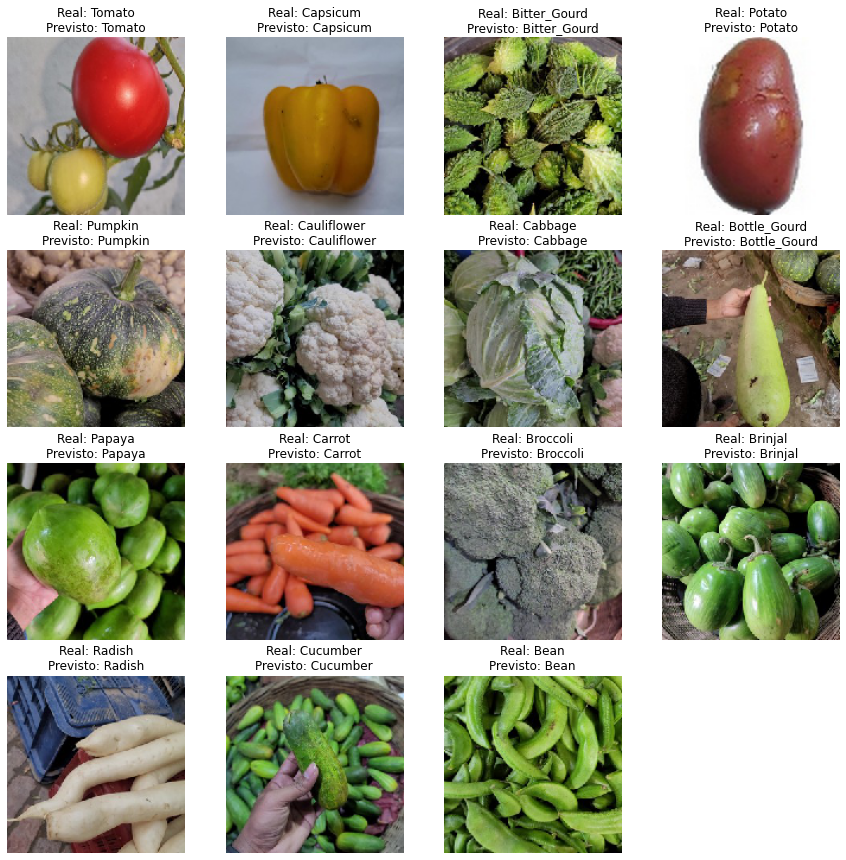

In [ ]:
classes = os.listdir("/content/Vegetable Images/validation")

plt.figure(figsize=(15,15))
for i, pasta in enumerate(classes):

  arquivo = os.listdir("/content/Vegetable Images/validation/"+pasta)
  imagens = ["/content/Vegetable Images/validation/"+pasta+"/"+file for file in arquivo]
  escolha = np.random.choice(imagens)

  img = load_img(escolha, target_size=(150, 150))
  image = img_to_array(img)/255
  image = np.expand_dims(image, axis=0)

  indice = np.argmax(modelo.predict(image))
  dictclasses = valida.class_indices
  previsao = list(dictclasses.keys())[indice]


  plt.subplot(4,4,i+1)
  plt.imshow(img)
  plt.title(f"Real: {pasta}\nPrevisto: {previsao}")
  plt.axis('off')

